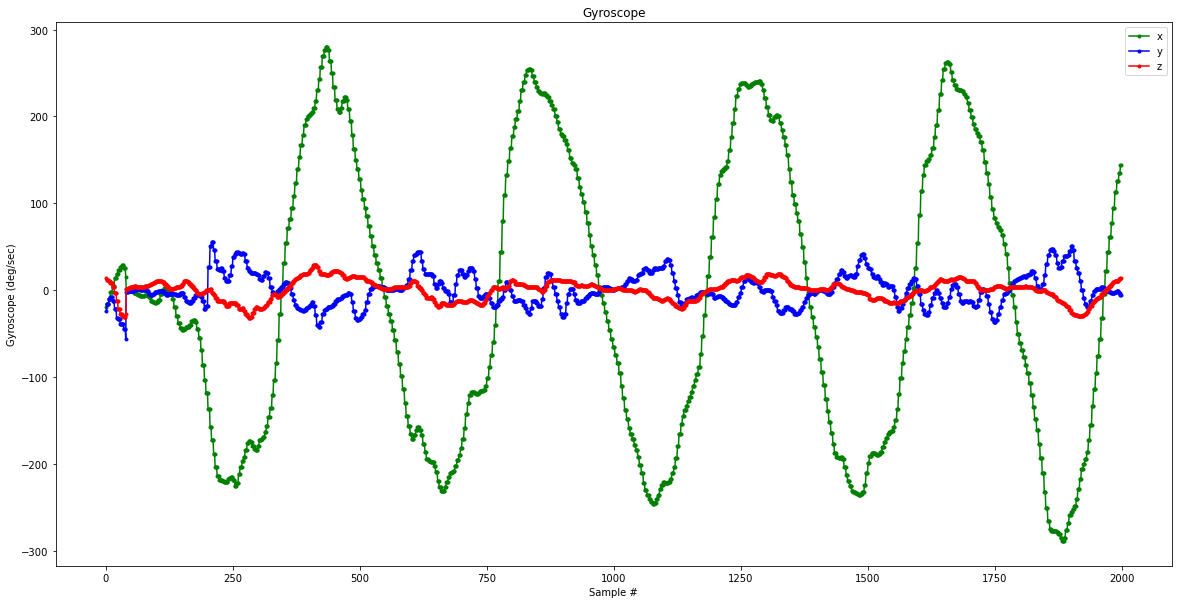

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "updown.csv"

df = pd.read_csv(filename)

index = range(1, len(df['x']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['x'], 'g.', label='x', linestyle='solid')
plt.plot(index, df['y'], 'b.', label='y', linestyle='solid')
plt.plot(index, df['z'], 'r.', label='z', linestyle='solid')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "estacionario",
    "updown",
    "leftright"
]

TensorFlow version = 2.9.1



In [6]:
SAMPLES_PER_GESTURE = 39

In [9]:
NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = pd.read_csv(gesture + ".csv")
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

Processing index 0 for gesture 'estacionario'.
	There are 51 recordings of the estacionario gesture.
Processing index 1 for gesture 'updown'.
	There are 51 recordings of the updown gesture.
Processing index 2 for gesture 'leftright'.
	There are 51 recordings of the leftright gesture.


In [10]:
 
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['x'][index] + 500) / 1000,
          (df['y'][index] + 500) / 1000,
          (df['z'][index] + 500) / 1000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

Data set parsing and preparation complete.


# Randomize

In [11]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


# Build and Train

In [12]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(150, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=600, batch_size=1, validation_data=(inputs_validate, outputs_validate))
model.summary()

Epoch 1/600
30/30 [==============================] - 1s 5ms/step - loss: 0.0159 - mae: 0.0615 - val_loss: 1.4237e-04 - val_mae: 0.0111
Epoch 2/600
30/30 [==============================] - 0s 2ms/step - loss: 4.3050e-05 - mae: 0.0057 - val_loss: 9.3839e-06 - val_mae: 0.0028
Epoch 3/600
30/30 [==============================] - 0s 2ms/step - loss: 3.5395e-06 - mae: 0.0016 - val_loss: 9.1131e-07 - val_mae: 8.7872e-04
Epoch 4/600
30/30 [==============================] - 0s 2ms/step - loss: 3.2349e-07 - mae: 4.9265e-04 - val_loss: 7.2274e-08 - val_mae: 2.4521e-04
Epoch 5/600
30/30 [==============================] - 0s 2ms/step - loss: 3.0687e-08 - mae: 1.5814e-04 - val_loss: 1.5931e-08 - val_mae: 1.1446e-04
Epoch 6/600
30/30 [==============================] - 0s 2ms/step - loss: 8.5064e-09 - mae: 8.3069e-05 - val_loss: 5.8470e-09 - val_mae: 6.9067e-05
Epoch 7/600
30/30 [==============================] - 0s 2ms/step - loss: 3.4151e-09 - mae: 5.2496e-05 - val_loss: 2.7031e-09 - val_mae: 4.6816

30/30 [==============================] - 0s 1ms/step - loss: 3.1945e-11 - mae: 5.0519e-06 - val_loss: 3.9671e-11 - val_mae: 5.5778e-06
Epoch 57/600
30/30 [==============================] - 0s 2ms/step - loss: 3.1234e-11 - mae: 4.9934e-06 - val_loss: 3.8682e-11 - val_mae: 5.5088e-06
Epoch 58/600
30/30 [==============================] - 0s 2ms/step - loss: 3.0616e-11 - mae: 4.9442e-06 - val_loss: 3.7975e-11 - val_mae: 5.4588e-06
Epoch 59/600
30/30 [==============================] - 0s 2ms/step - loss: 2.9937e-11 - mae: 4.8915e-06 - val_loss: 3.7193e-11 - val_mae: 5.3989e-06
Epoch 60/600
30/30 [==============================] - 0s 2ms/step - loss: 2.9397e-11 - mae: 4.8427e-06 - val_loss: 3.6467e-11 - val_mae: 5.3469e-06
Epoch 61/600
30/30 [==============================] - 0s 2ms/step - loss: 2.8851e-11 - mae: 4.7983e-06 - val_loss: 3.5780e-11 - val_mae: 5.2956e-06
Epoch 62/600
30/30 [==============================] - 0s 2ms/step - loss: 2.8256e-11 - mae: 4.7468e-06 - val_loss: 3.5163e-11

30/30 [==============================] - 0s 2ms/step - loss: 1.4398e-11 - mae: 3.3816e-06 - val_loss: 1.8143e-11 - val_mae: 3.7621e-06
Epoch 112/600
30/30 [==============================] - 0s 2ms/step - loss: 1.4268e-11 - mae: 3.3662e-06 - val_loss: 1.7920e-11 - val_mae: 3.7382e-06
Epoch 113/600
30/30 [==============================] - 0s 2ms/step - loss: 1.4136e-11 - mae: 3.3515e-06 - val_loss: 1.7860e-11 - val_mae: 3.7290e-06
Epoch 114/600
30/30 [==============================] - 0s 2ms/step - loss: 1.4023e-11 - mae: 3.3364e-06 - val_loss: 1.7567e-11 - val_mae: 3.7018e-06
Epoch 115/600
30/30 [==============================] - 0s 2ms/step - loss: 1.3915e-11 - mae: 3.3229e-06 - val_loss: 1.7427e-11 - val_mae: 3.6856e-06
Epoch 116/600
30/30 [==============================] - 0s 2ms/step - loss: 1.3736e-11 - mae: 3.3029e-06 - val_loss: 1.7323e-11 - val_mae: 3.6731e-06
Epoch 117/600
30/30 [==============================] - 0s 2ms/step - loss: 1.3591e-11 - mae: 3.2844e-06 - val_loss: 1.70

30/30 [==============================] - 0s 2ms/step - loss: 9.2528e-12 - mae: 2.7066e-06 - val_loss: 1.1715e-11 - val_mae: 3.0155e-06
Epoch 167/600
30/30 [==============================] - 0s 2ms/step - loss: 9.1913e-12 - mae: 2.6967e-06 - val_loss: 1.1627e-11 - val_mae: 3.0033e-06
Epoch 168/600
30/30 [==============================] - 0s 2ms/step - loss: 9.1156e-12 - mae: 2.6857e-06 - val_loss: 1.1535e-11 - val_mae: 2.9912e-06
Epoch 169/600
30/30 [==============================] - 0s 1ms/step - loss: 9.0526e-12 - mae: 2.6774e-06 - val_loss: 1.1372e-11 - val_mae: 2.9755e-06
Epoch 170/600
30/30 [==============================] - 0s 1ms/step - loss: 8.9993e-12 - mae: 2.6691e-06 - val_loss: 1.1347e-11 - val_mae: 2.9707e-06
Epoch 171/600
30/30 [==============================] - 0s 2ms/step - loss: 8.9244e-12 - mae: 2.6583e-06 - val_loss: 1.1305e-11 - val_mae: 2.9623e-06
Epoch 172/600
30/30 [==============================] - 0s 2ms/step - loss: 8.8524e-12 - mae: 2.6474e-06 - val_loss: 1.12

30/30 [==============================] - 0s 2ms/step - loss: 6.7848e-12 - mae: 2.3139e-06 - val_loss: 8.5595e-12 - val_mae: 2.5748e-06
Epoch 222/600
30/30 [==============================] - 0s 2ms/step - loss: 6.7525e-12 - mae: 2.3083e-06 - val_loss: 8.5455e-12 - val_mae: 2.5716e-06
Epoch 223/600
30/30 [==============================] - 0s 2ms/step - loss: 6.7009e-12 - mae: 2.3016e-06 - val_loss: 8.5157e-12 - val_mae: 2.5649e-06
Epoch 224/600
30/30 [==============================] - 0s 2ms/step - loss: 6.6456e-12 - mae: 2.2921e-06 - val_loss: 8.5021e-12 - val_mae: 2.5618e-06
Epoch 225/600
30/30 [==============================] - 0s 1ms/step - loss: 6.6165e-12 - mae: 2.2867e-06 - val_loss: 8.4111e-12 - val_mae: 2.5515e-06
Epoch 226/600
30/30 [==============================] - 0s 2ms/step - loss: 6.5797e-12 - mae: 2.2800e-06 - val_loss: 8.3339e-12 - val_mae: 2.5412e-06
Epoch 227/600
30/30 [==============================] - 0s 2ms/step - loss: 6.5338e-12 - mae: 2.2719e-06 - val_loss: 8.28

30/30 [==============================] - 0s 2ms/step - loss: 5.3157e-12 - mae: 2.0472e-06 - val_loss: 6.7915e-12 - val_mae: 2.2885e-06
Epoch 277/600
30/30 [==============================] - 0s 1ms/step - loss: 5.2984e-12 - mae: 2.0437e-06 - val_loss: 6.7461e-12 - val_mae: 2.2827e-06
Epoch 278/600
30/30 [==============================] - 0s 2ms/step - loss: 5.2866e-12 - mae: 2.0404e-06 - val_loss: 6.6999e-12 - val_mae: 2.2769e-06
Epoch 279/600
30/30 [==============================] - 0s 2ms/step - loss: 5.2465e-12 - mae: 2.0345e-06 - val_loss: 6.6616e-12 - val_mae: 2.2711e-06
Epoch 280/600
30/30 [==============================] - 0s 1ms/step - loss: 5.2347e-12 - mae: 2.0312e-06 - val_loss: 6.6530e-12 - val_mae: 2.2689e-06
Epoch 281/600
30/30 [==============================] - 0s 2ms/step - loss: 5.2116e-12 - mae: 2.0265e-06 - val_loss: 6.6445e-12 - val_mae: 2.2667e-06
Epoch 282/600
30/30 [==============================] - 0s 2ms/step - loss: 5.1826e-12 - mae: 2.0206e-06 - val_loss: 6.63

30/30 [==============================] - 0s 2ms/step - loss: 4.3978e-12 - mae: 1.8585e-06 - val_loss: 5.5973e-12 - val_mae: 2.0778e-06
Epoch 332/600
30/30 [==============================] - 0s 2ms/step - loss: 4.3741e-12 - mae: 1.8543e-06 - val_loss: 5.5913e-12 - val_mae: 2.0761e-06
Epoch 333/600
30/30 [==============================] - 0s 2ms/step - loss: 4.3526e-12 - mae: 1.8503e-06 - val_loss: 5.5854e-12 - val_mae: 2.0744e-06
Epoch 334/600
30/30 [==============================] - 0s 2ms/step - loss: 4.3480e-12 - mae: 1.8487e-06 - val_loss: 5.5157e-12 - val_mae: 2.0655e-06
Epoch 335/600
30/30 [==============================] - 0s 2ms/step - loss: 4.3314e-12 - mae: 1.8459e-06 - val_loss: 5.4767e-12 - val_mae: 2.0603e-06
Epoch 336/600
30/30 [==============================] - 0s 2ms/step - loss: 4.2857e-12 - mae: 1.8391e-06 - val_loss: 5.4584e-12 - val_mae: 2.0550e-06
Epoch 337/600
30/30 [==============================] - 0s 2ms/step - loss: 4.2750e-12 - mae: 1.8363e-06 - val_loss: 5.43

30/30 [==============================] - 0s 1ms/step - loss: 3.7041e-12 - mae: 1.7068e-06 - val_loss: 4.7559e-12 - val_mae: 1.9132e-06
Epoch 387/600
30/30 [==============================] - 0s 2ms/step - loss: 3.7007e-12 - mae: 1.7056e-06 - val_loss: 4.7348e-12 - val_mae: 1.9083e-06
Epoch 388/600
30/30 [==============================] - 0s 2ms/step - loss: 3.6973e-12 - mae: 1.7044e-06 - val_loss: 4.7304e-12 - val_mae: 1.9069e-06
Epoch 389/600
30/30 [==============================] - 0s 2ms/step - loss: 3.6890e-12 - mae: 1.7019e-06 - val_loss: 4.6947e-12 - val_mae: 1.9020e-06
Epoch 390/600
30/30 [==============================] - 0s 2ms/step - loss: 3.6758e-12 - mae: 1.6981e-06 - val_loss: 4.6904e-12 - val_mae: 1.9007e-06
Epoch 391/600
30/30 [==============================] - 0s 2ms/step - loss: 3.6724e-12 - mae: 1.6969e-06 - val_loss: 4.6439e-12 - val_mae: 1.8922e-06
Epoch 392/600
30/30 [==============================] - 0s 2ms/step - loss: 3.6591e-12 - mae: 1.6944e-06 - val_loss: 4.63

30/30 [==============================] - 0s 2ms/step - loss: 3.2161e-12 - mae: 1.5883e-06 - val_loss: 4.1100e-12 - val_mae: 1.7793e-06
Epoch 442/600
30/30 [==============================] - 0s 2ms/step - loss: 3.2135e-12 - mae: 1.5873e-06 - val_loss: 4.1067e-12 - val_mae: 1.7782e-06
Epoch 443/600
30/30 [==============================] - 0s 1ms/step - loss: 3.2016e-12 - mae: 1.5851e-06 - val_loss: 4.1034e-12 - val_mae: 1.7772e-06
Epoch 444/600
30/30 [==============================] - 0s 1ms/step - loss: 3.1894e-12 - mae: 1.5828e-06 - val_loss: 4.1001e-12 - val_mae: 1.7761e-06
Epoch 445/600
30/30 [==============================] - 0s 2ms/step - loss: 3.1869e-12 - mae: 1.5818e-06 - val_loss: 4.0969e-12 - val_mae: 1.7750e-06
Epoch 446/600
30/30 [==============================] - 0s 2ms/step - loss: 3.1666e-12 - mae: 1.5782e-06 - val_loss: 4.0936e-12 - val_mae: 1.7740e-06
Epoch 447/600
30/30 [==============================] - 0s 1ms/step - loss: 3.1641e-12 - mae: 1.5773e-06 - val_loss: 4.09

30/30 [==============================] - 0s 2ms/step - loss: 2.8684e-12 - mae: 1.4989e-06 - val_loss: 3.6331e-12 - val_mae: 1.6751e-06
Epoch 497/600
30/30 [==============================] - 0s 2ms/step - loss: 2.8664e-12 - mae: 1.4981e-06 - val_loss: 3.6305e-12 - val_mae: 1.6742e-06
Epoch 498/600
30/30 [==============================] - 0s 2ms/step - loss: 2.8476e-12 - mae: 1.4947e-06 - val_loss: 3.6279e-12 - val_mae: 1.6733e-06
Epoch 499/600
30/30 [==============================] - 0s 2ms/step - loss: 2.8423e-12 - mae: 1.4925e-06 - val_loss: 3.6155e-12 - val_mae: 1.6688e-06
Epoch 500/600
30/30 [==============================] - 0s 2ms/step - loss: 2.8402e-12 - mae: 1.4917e-06 - val_loss: 3.6129e-12 - val_mae: 1.6679e-06
Epoch 501/600
30/30 [==============================] - 0s 2ms/step - loss: 2.8254e-12 - mae: 1.4869e-06 - val_loss: 3.6104e-12 - val_mae: 1.6670e-06
Epoch 502/600
30/30 [==============================] - 0s 2ms/step - loss: 2.8154e-12 - mae: 1.4849e-06 - val_loss: 3.59

30/30 [==============================] - 0s 2ms/step - loss: 2.5366e-12 - mae: 1.4120e-06 - val_loss: 3.2589e-12 - val_mae: 1.5831e-06
Epoch 552/600
30/30 [==============================] - 0s 2ms/step - loss: 2.5350e-12 - mae: 1.4113e-06 - val_loss: 3.2568e-12 - val_mae: 1.5823e-06
Epoch 553/600
30/30 [==============================] - 0s 2ms/step - loss: 2.5334e-12 - mae: 1.4106e-06 - val_loss: 3.2319e-12 - val_mae: 1.5779e-06
Epoch 554/600
30/30 [==============================] - 0s 2ms/step - loss: 2.5247e-12 - mae: 1.4086e-06 - val_loss: 3.2299e-12 - val_mae: 1.5772e-06
Epoch 555/600
30/30 [==============================] - 0s 2ms/step - loss: 2.5230e-12 - mae: 1.4079e-06 - val_loss: 3.2278e-12 - val_mae: 1.5764e-06
Epoch 556/600
30/30 [==============================] - 0s 2ms/step - loss: 2.5214e-12 - mae: 1.4072e-06 - val_loss: 3.2258e-12 - val_mae: 1.5757e-06
Epoch 557/600
30/30 [==============================] - 0s 2ms/step - loss: 2.5198e-12 - mae: 1.4065e-06 - val_loss: 3.22

Total params: 38,003
Trainable params: 38,003
Non-trainable params: 0
_________________________________________________________________


# Graph the Lost

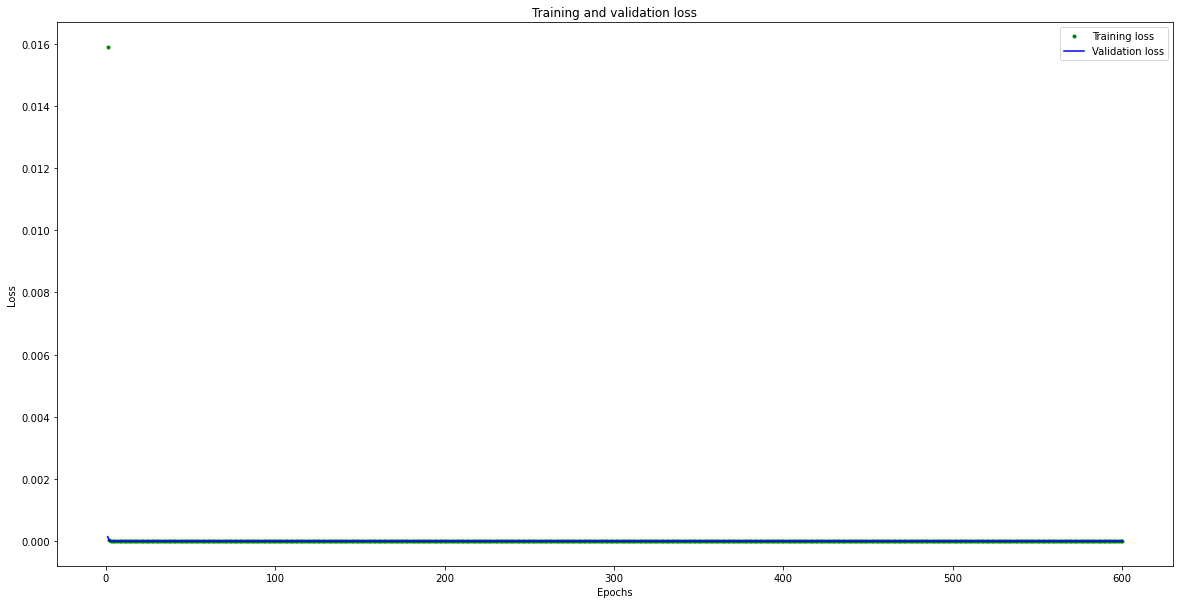

[20.0, 10.0]


In [14]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

# Graph Loss Again

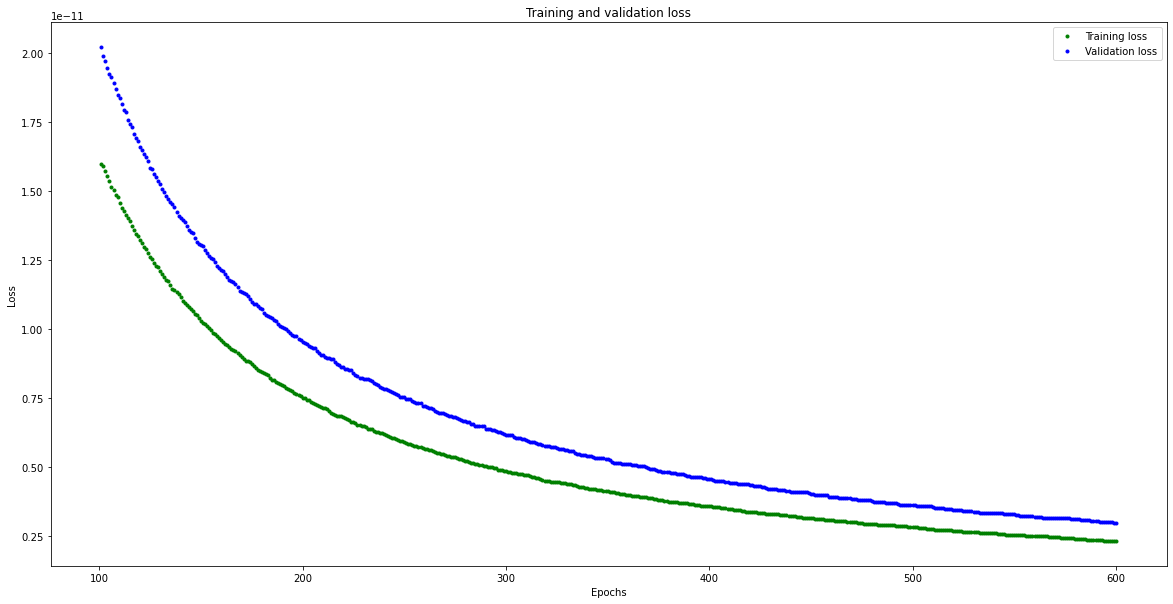

In [15]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Mean absolute error

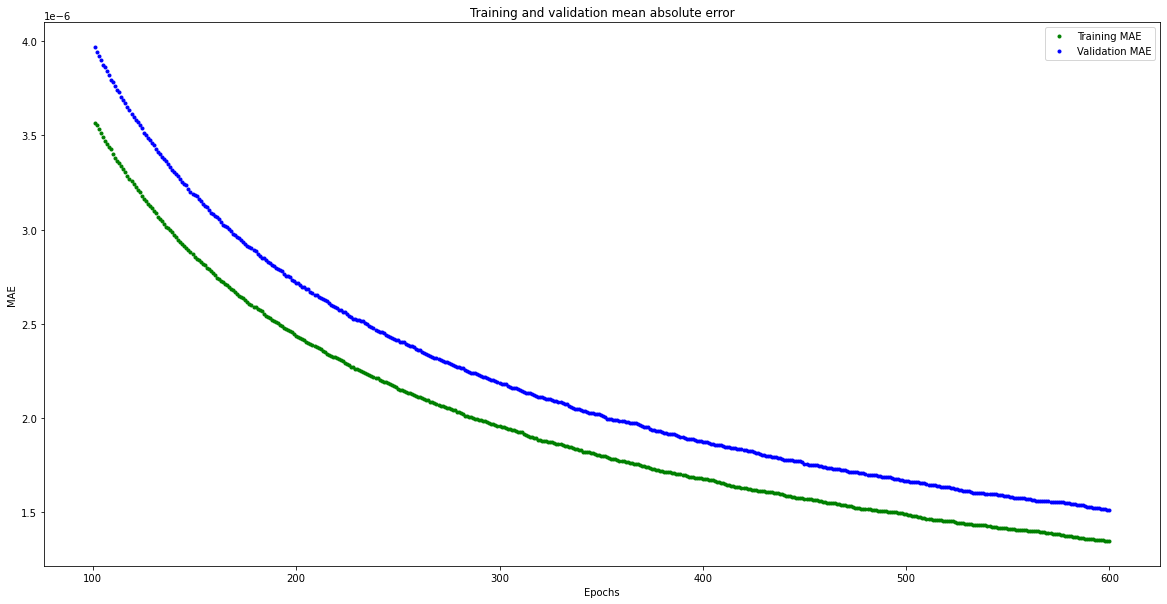

In [17]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Verify


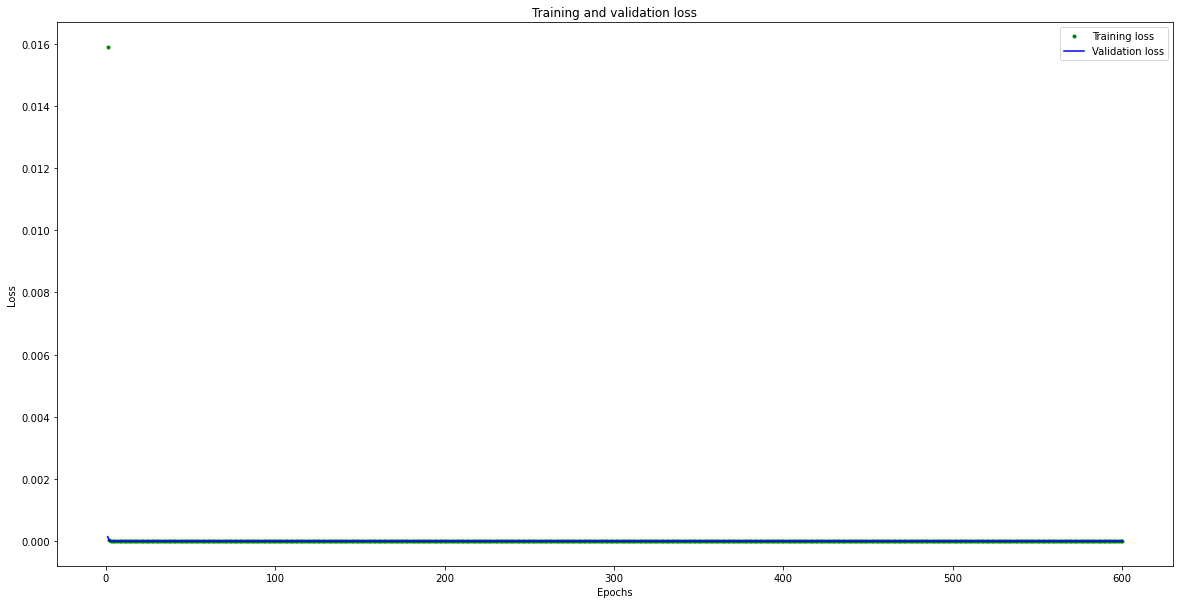

[20.0, 10.0]


In [18]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

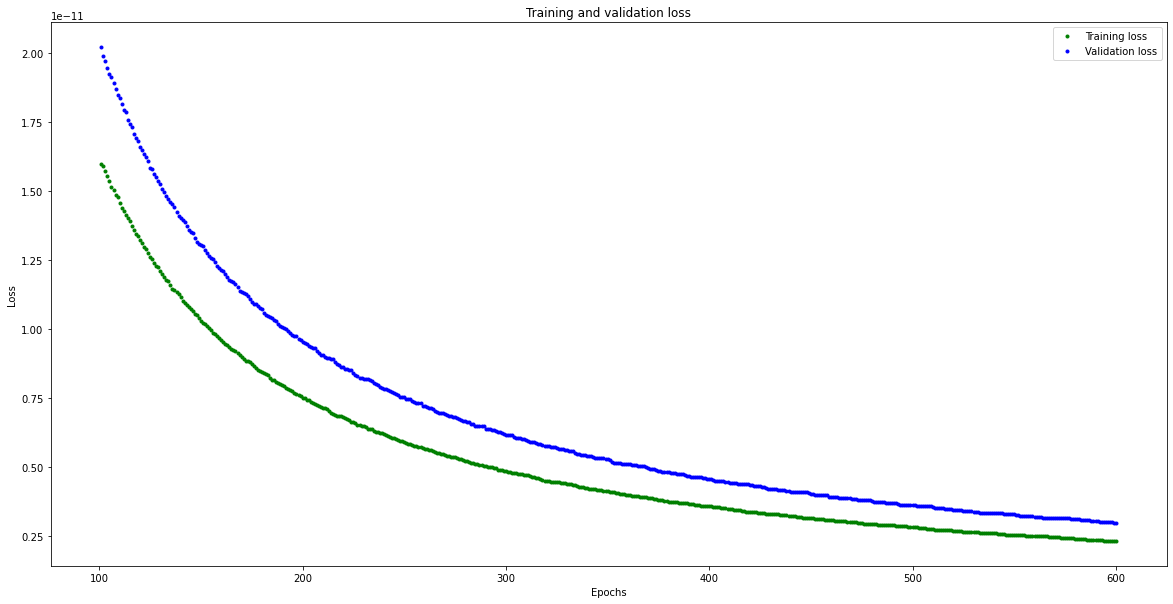

In [19]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

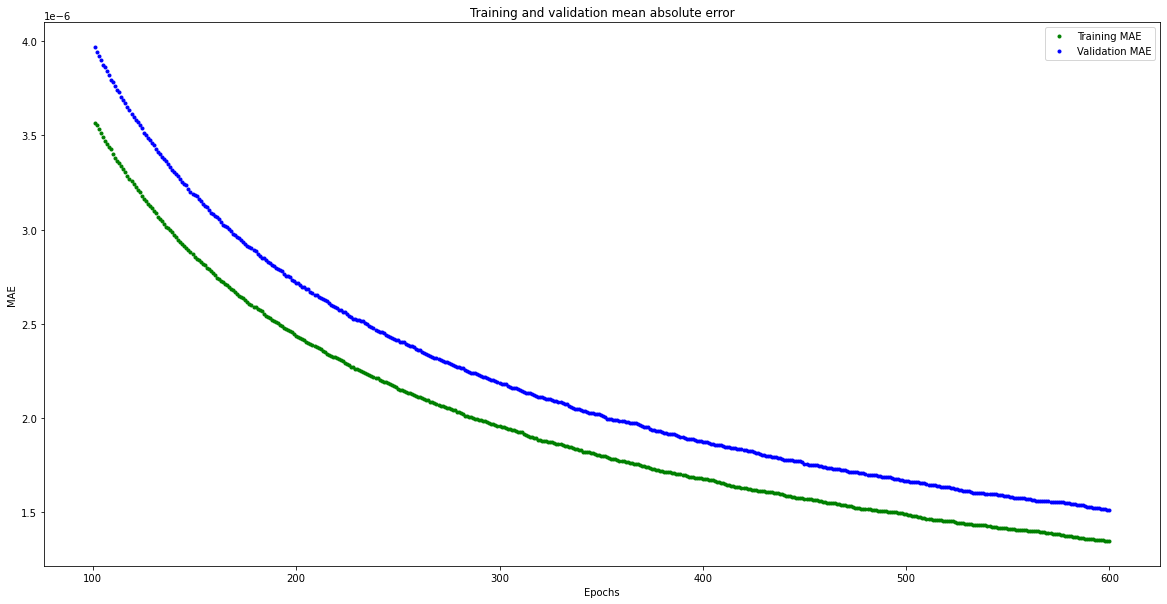

In [20]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [21]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  

INFO:tensorflow:Assets written to: C:\Users\Matias\AppData\Local\Temp\tmpgx3fc4_o\assets
Model is 154440 bytes


1/1 [==============================] - 0s 16ms/step
predictions =
 [[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [nan nan nan]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]
actual =
 [[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


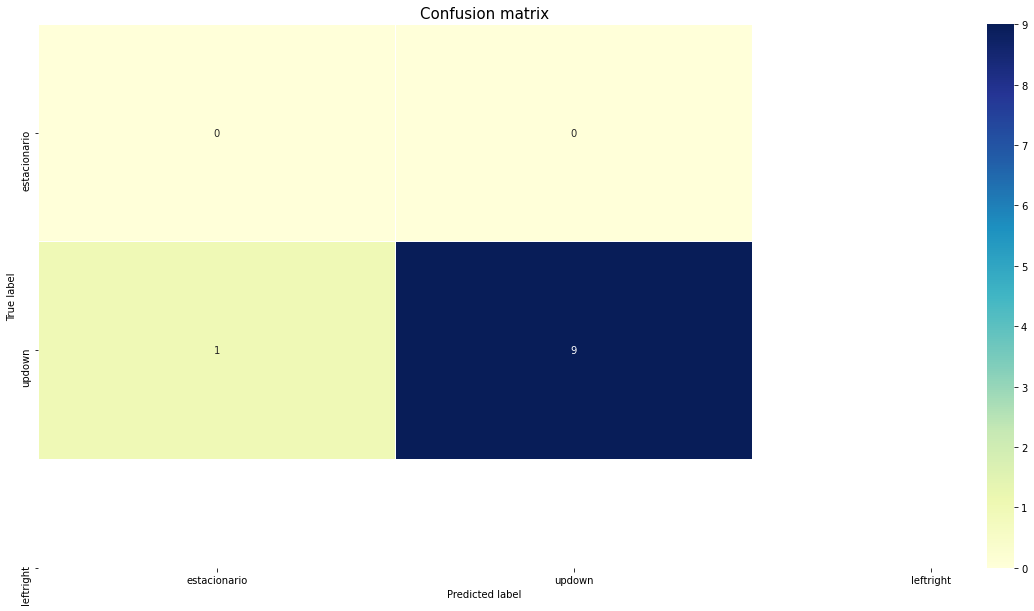

In [25]:
import sklearn as sk
import seaborn as sns
from sklearn import metrics

#Run with test data
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

class_labels = GESTURES
max_test = np.argmax(outputs_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()